# Assignment: Practical Dashboards
---
## Retrieve connection strings, passwords, or secrets from JSON file
---

In [1]:
import json

# Demonstration of how to load a file that contains secrets without accidentally leaking those secrets
with open('/Users/ariadnear/Documents/aris-secrets.json') as f:
    data = json.load(f)

    # If you want your data to be secure, don't print this variable out!
    # Jupyter will retain a cached version of any printed data and it can be
    # accidentally committed to version control.
    secret_key = data["mongodb"]

# We can safely print the length of the secret key. That won't leak any sensitive information.
print(f"My secret key is {len(secret_key)} characters in length.")

My secret key is 66 characters in length.


---
## Conect to a MongoDB Server
---

In [2]:
import pymongo
import certifi

# Once you have retrieved your connection string from a secrets file, use it here
mongo_connection_string = data['mongodb']

# Connect to the database using known good certificates
client = pymongo.MongoClient(mongo_connection_string, tlsCAFile=certifi.where())

# Fetch the database named "DA320"
da320_database = client['DA320']

# Within the database we have "collections". Think of them as tables in SQL.
allCollections = da320_database.list_collection_names()

# Here is the list of collections within my database
print(f"Using MongoDB version {client.server_info()['version']}.")
print(f"This database has the collections {allCollections}")

Using MongoDB version 6.0.11.
This database has the collections ['imdb', 'MetacriticMovie', 'IMDB_Pipeline_View']


---
## Fetch a collection from a MongoDB Server
---

In [3]:
import pandas as pd

# Fetch an aggregate view as if it is a collection
cursor = da320_database["IMDB_Pipeline_View"].find()
imdb = pd.DataFrame(cursor)
imdb.head()

,_id,id,title,runtime,user_rating,votes,release_date,budget,opening_weekend,gross_sales,ratings_trimmed,genres,cast,director,producer,company,release_year,release_month,release_day,mpaa_rating
0,6545770bb3a97e2eaf71b8fc,77631,Grease,110.0,7.2,265183,1978-06-13,6000000.0,60759.0,394955690.0,"[TV-14, (D)]","[Comedy, Musical, Romance]","[John Travolta, Olivia Newton-John, Stockard C...",[Randal Kleiser],"[Allan Carr, Neil A. Machlis, Robert Stigwood]","[Paramount Pictures, Robert Stigwood Organizat...",1978,6,13,TV-14
1,6545770bb3a97e2eaf71b8fd,78346,Superman,143.0,7.4,172769,1978-12-10,55000000.0,7465343.0,166200000.0,"[TV-PG, (LV)]","[Action, Adventure, Sci-Fi]","[Marlon Brando, Gene Hackman, Christopher Reev...",[Richard Donner],"[Charles Greenlaw, Richard Lester, Alexander S...","[Dovemead Films, Film Export A.G., Internation...",1978,12,10,TV-PG
2,6545770bb3a97e2eaf71b8fe,77416,The Deer Hunter,183.0,8.1,334827,1978-12-08,15000000.0,NaN,NaN,[R],"[Drama, War]","[Robert De Niro, John Cazale, John Savage, Chr...",[Michael Cimino],"[Joann Carelli, Michael Cimino, Michael Deeley...","[EMI Films, Universal Pictures]",1978,12,8,R
3,6545770bb3a97e2eaf71b8ff,77651,Halloween,91.0,7.7,267109,1978-10-25,300000.0,NaN,70000000.0,[TV-14],"[Horror, Thriller]","[Donald Pleasence, Jamie Lee Curtis, Nancy Kye...",[John Carpenter],"[Moustapha Akkad, John Carpenter, Debra Hill, ...","[Compass International Pictures, Falcon Intern...",1978,10,25,TV-14
4,6545770bb3a97e2eaf71b900,77975,National Lampoon's Animal House,109.0,7.4,119917,1978-07-27,3000000.0,201747.0,3371006.0,"[TV-14, (DLSV, TV Rating.)]",[Comedy],"[Tom Hulce, Stephen Furst, Mark Metcalf, Mary ...",[John Landis],"[Ivan Reitman, Matty Simmons]","[Universal Pictures, Oregon Film Factory, Stag...",1978,7,27,TV-14


---
## My MongoDB Pipeline
---

```
[
    {
        '$project': {
            'id': '$id', 
            'title': '$title', 
            'runtime': {
                '$toInt': '$runtime'
            }, 
            'user_rating': {
                '$convert': {
                    'input': '$user_rating', 
                    'to': 'double', 
                    'onError': None
                }
            }, 
            'votes': {
                '$convert': {
                    'input': '$votes', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'release_date': {
                '$convert': {
                    'input': '$release_date', 
                    'to': 'date', 
                    'onError': None
                }
            }, 
            'budget': {
                '$convert': {
                    'input': '$budget', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'opening_weekend': {
                '$convert': {
                    'input': '$opening_weekend', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'gross_sales': {
                '$convert': {
                    'input': '$gross_sales', 
                    'to': 'long', 
                    'onError': None
                }
            }, 
            'ratings_trimmed': {
                '$map': {
                    'input': {
                        '$split': [
                            '$mpaa_rating', '::'
                        ]
                    }, 
                    'as': 'rating_split', 
                    'in': {
                        '$trim': {
                            'input': '$$rating_split'
                        }
                    }
                }
            }, 
            'genres': {
                '$split': [
                    '$genres', ', '
                ]
            }, 
            'cast': {
                '$split': [
                    '$cast', ', '
                ]
            }, 
            'director': {
                '$split': [
                    '$director', ', '
                ]
            }, 
            'producer': {
                '$split': [
                    '$producer', ', '
                ]
            }, 
            'company': {
                '$split': [
                    {
                        '$toString': '$company'
                    }, ', '
                ]
            }
        }
    }, {
        '$addFields': {
            'release_year': {
                '$year': '$release_date'
            }, 
            'release_month': {
                '$month': '$release_date'
            }, 
            'release_day': {
                '$dayOfMonth': '$release_date'
            }, 
            'mpaa_rating': {
                '$arrayElemAt': [
                    '$ratings_trimmed', 0
                ]
            }
        }
    }
]
```

---
## Fetching and Charting Data
---

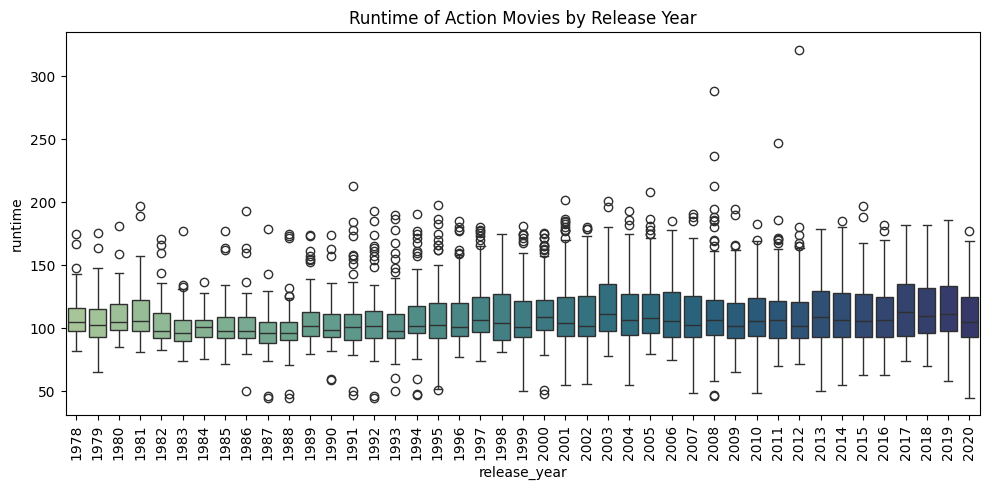

In [4]:
from matplotlib import pyplot
import seaborn as sns

# Query from MongoDB
query = {
    'genres': {
        '$in': [
            'Action'
        ]
    }
}


# Execute this query, produce a cursor and Pandas dataframe
cursor = da320_database["IMDB_Pipeline_View"].find(query)
action_films = pd.DataFrame(cursor)

# Set the figure size
pyplot.rcParams["figure.figsize"] = [10, 5]
pyplot.rcParams["figure.autolayout"] = True

# Chart trends over time with boxplots
chart = sns.boxplot(data= action_films, x="release_year", y= "runtime", hue=action_films["release_year"], legend=False, palette="crest")
chart.set_title('Runtime of Action Movies by Release Year')
for item in chart.get_xticklabels():
    item.set_rotation(90)

[Text(0.5, 1.0, 'Revenue vs Ratings for 2015 Movies in IMDB')]

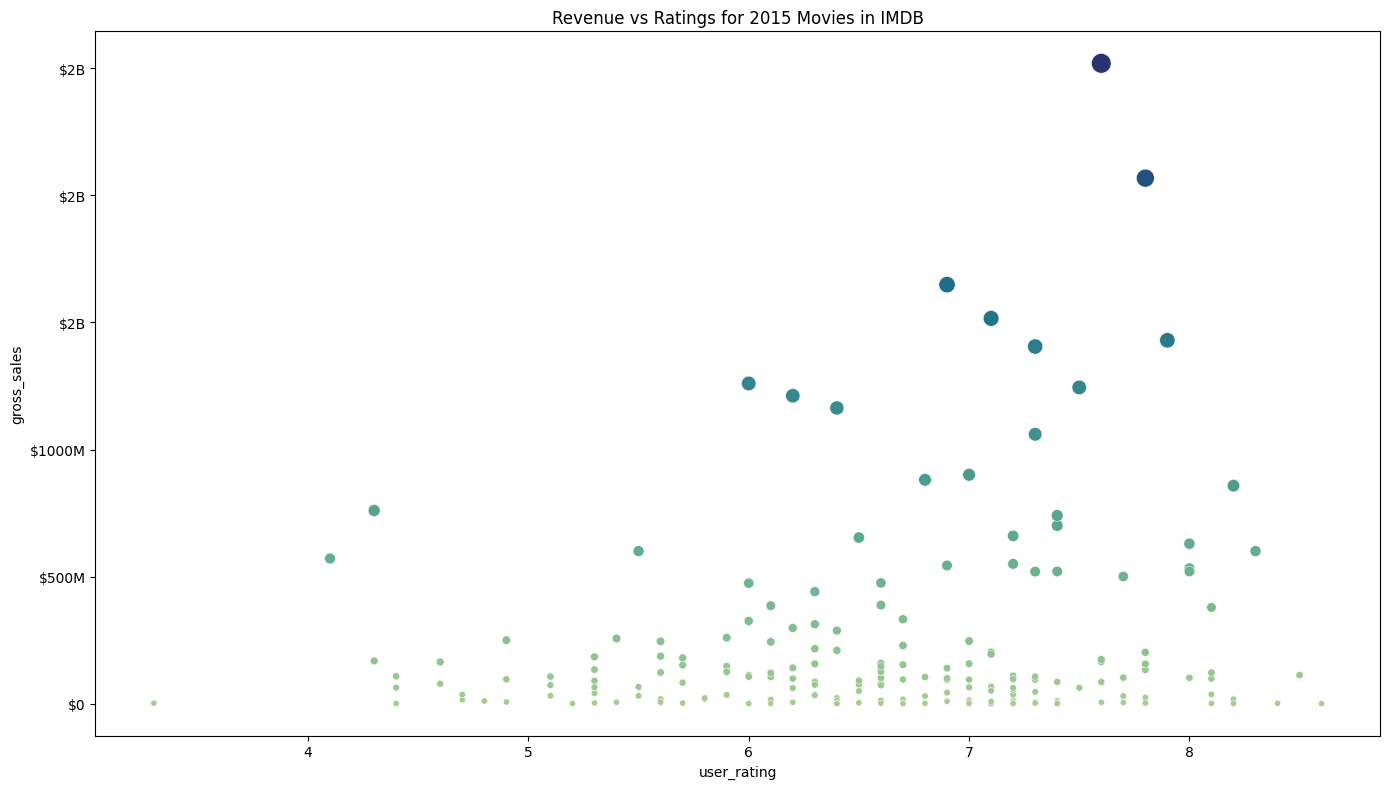

In [23]:
# Filter to a specific year
selected_films = imdb[imdb["release_year"] == 2015]

# A custom formatter for currency
def format_currency(amount, _):
    if amount > 1_000_000_000_000:
        return f"${round(amount / 1_000_000_000_000)}T"
    elif amount > 1_000_000_000:
        return f"${round(amount / 1_000_000_000)}B"
    elif amount > 1_000_000:
        return f"${round(amount / 1_000_000)}M"
    elif amount > 1_000:
        return f"${round(amount / 1_000)}K"
    else:
        return f"${round(amount)}"
    
# Plot Gross Sales vs Ratings
pyplot.gca().yaxis.set_major_formatter(format_currency)
sns.scatterplot(x="user_rating", y="gross_sales", data= selected_films, hue="gross_sales", size="gross_sales", sizes=(20, 200), legend=False, palette="crest").set(title='Revenue vs Ratings for 2015 Movies in IMDB')

[Text(0.5, 1.0, 'Count of Movies vs Release Year in IMDB')]

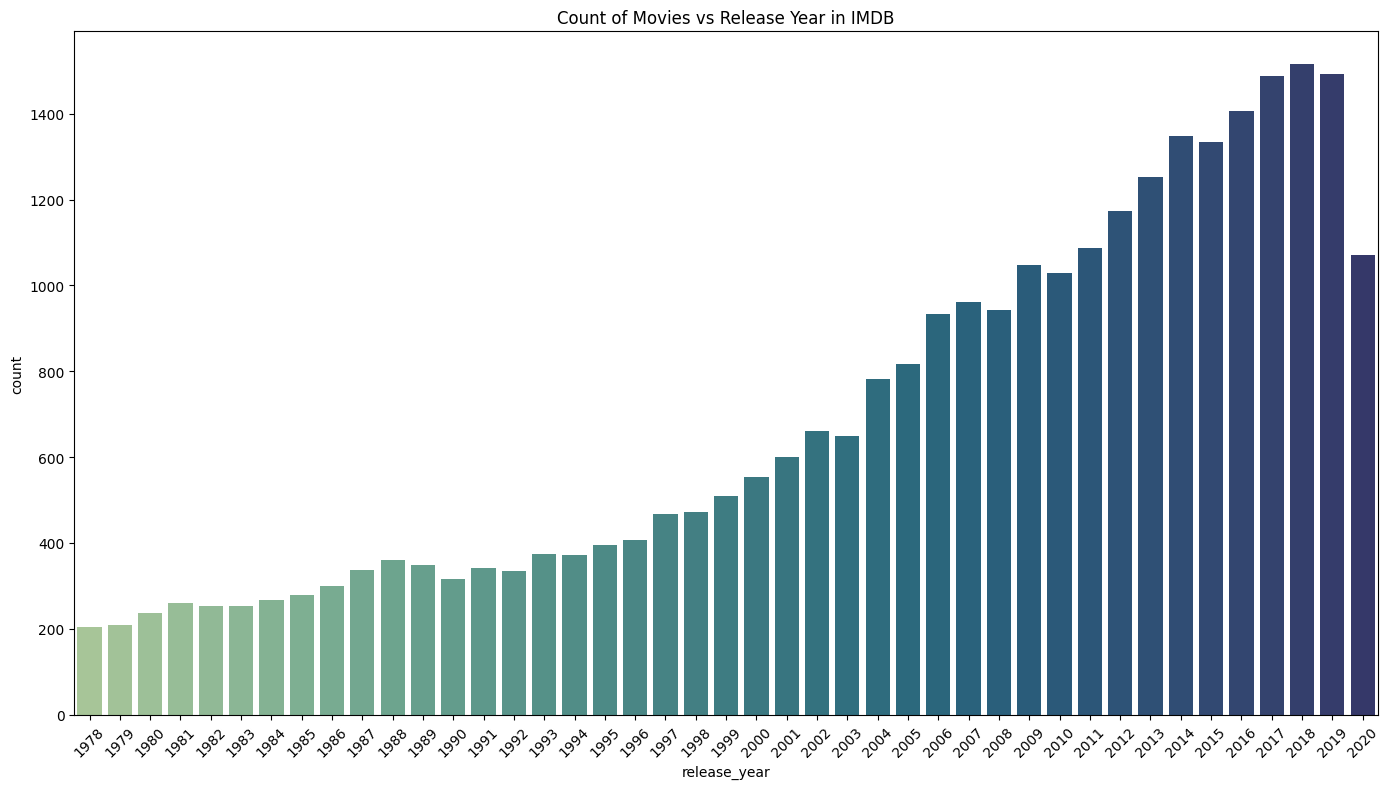

In [6]:
# Set the figure size
pyplot.rcParams["figure.figsize"] = [14, 8]
pyplot.rcParams["figure.autolayout"] = True

# Bar plot of Movies by Release Year
pyplot.xticks(rotation = 45)
sns.countplot(data=imdb, x="release_year", hue="release_year", legend=False, palette="crest").set(title='Count of Movies vs Release Year in IMDB')

---
## Chart Insights
---

#### Chart 1: Runtime of Action Movies by Release Year
This chart shows a runtime boxplot of Action Movies for every release year in the IMDB database. We can see that the runtime throughout the years for Action movies is pretty consistent. Some outliers are present but the runtime average is slightly above 100 minutes in the 43 years that form part of the chart. In addition to that, the boxplot range increased in the years of the second half, however this is due to a greater number of action movies being released during those years as we will see in the third chart.

#### Chart 2: Revenue vs Ratings for 2015 Movies in IMDB
In this graph, we would expect higher revenue for movies that have a high user rating, however we see that this is not always the case. The movie with the highest revenue in 2015 has a user rating of 7.6. In comparison, some movies with a high user rating have a very low revenue. I think user rating can still be a good revenue predictor. However, there are other factors that should be reviewed, such as the number of users who rate each movie, or how much marketing is done previously to a movie release that could affect ticket sales. 

#### Chart 3: Count of Movies vs Release Year in IMDB
The last graph summarizes the number of movies released each year from 1978 to 2020. We see that the number of movies released has increased steadily over the years with the only exception of 2020. When the pandemic started, fewer movies were released.

In [8]:
# Querying romance movies
cursor = da320_database["IMDB_Pipeline_View"].find({'genres': {'$in': ['Romance']}})

romance_films = pd.DataFrame(cursor)
romance_films.head()

,_id,id,title,runtime,user_rating,votes,release_date,budget,opening_weekend,gross_sales,ratings_trimmed,genres,cast,director,producer,company,release_year,release_month,release_day,mpaa_rating
0,6545770bb3a97e2eaf71b8fc,77631,Grease,110.0,7.2,265183,1978-06-13,6000000.0,60759.0,394955690.0,"[TV-14, (D)]","[Comedy, Musical, Romance]","[John Travolta, Olivia Newton-John, Stockard C...",[Randal Kleiser],"[Allan Carr, Neil A. Machlis, Robert Stigwood]","[Paramount Pictures, Robert Stigwood Organizat...",1978,6,13,TV-14
1,6545770bb3a97e2eaf71b901,77327,"China 9, Liberty 37",102.0,6.0,1212,1978-08-04,NaN,NaN,NaN,[R],"[Romance, Western]","[Warren Oates, Fabio Testi, Jenny Agutter, Sam...","[Monte Hellman, Tony Brandt]","[Gianni Bozzacchi, Valerio De Paolis, Rolf M. ...","[Aspa Producciones, Compagnia Europea Cinemato...",1978,8,4,R
2,6545770bb3a97e2eaf71b90d,77405,Days of Heaven,94.0,7.8,57676,1978-09-13,3000000.0,NaN,NaN,[PG],"[Drama, Romance]","[Richard Gere, Brooke Adams, Sam Shepard, Lind...",[Terrence Malick],"[Jacob Brackman, Bert Schneider, Harold Schnei...",[Paramount Pictures],1978,9,13,PG
3,6545770bb3a97e2eaf71b90f,77663,Heaven Can Wait,101.0,6.9,21157,1978-06-28,NaN,4192799.0,NaN,[PG],"[Comedy, Fantasy, Romance, Sport]","[Warren Beatty, Julie Christie, James Mason, J...","[Warren Beatty, Buck Henry]","[Warren Beatty, Hawk Koch, Charles H. Maguire]",[Paramount Pictures],1978,6,28,PG
4,6545770bb3a97e2eaf71b913,77360,Comes a Horseman,118.0,6.3,2846,1978-10-25,NaN,NaN,NaN,"[TV-PG, (TV Rating)]","[Drama, Romance, Western]","[James Caan, Jane Fonda, Jason Robards, George...",[Alan J. Pakula],"[Ronnie Caan, Robert Chartoff, Gene Kirkwood, ...",[Chartoff-Winkler Productions],1978,10,25,TV-PG


In [9]:
# Querying action movies
cursor = da320_database["IMDB_Pipeline_View"].find({'genres': {'$in': ['Action']}})

action_films = pd.DataFrame(cursor)
action_films.head()

,_id,id,title,runtime,user_rating,votes,release_date,budget,opening_weekend,gross_sales,ratings_trimmed,genres,cast,director,producer,company,release_year,release_month,release_day,mpaa_rating
0,6545770bb3a97e2eaf71b8fd,78346,Superman,143.0,7.4,172769,1978-12-10,55000000.0,7465343.0,166200000.0,"[TV-PG, (LV)]","[Action, Adventure, Sci-Fi]","[Marlon Brando, Gene Hackman, Christopher Reev...",[Richard Donner],"[Charles Greenlaw, Richard Lester, Alexander S...","[Dovemead Films, Film Export A.G., Internation...",1978,12,10,TV-PG
1,6545770bb3a97e2eaf71b90b,77523,Every Which Way but Loose,114.0,6.3,27296,1978-12-16,5000000.0,10272000.0,NaN,[PG],"[Action, Comedy]","[Clint Eastwood, Sondra Locke, Geoffrey Lewis,...",[James Fargo],"[Robert Daley, Jeremy Joe Kronsberg, Fritz Manes]","[Warner Bros., The Malpaso Company]",1978,12,16,PG
2,6545770bb3a97e2eaf71b914,77369,Convoy,110.0,6.3,16757,1978-06-10,12000000.0,NaN,NaN,[PG],"[Action, Drama]","[Kris Kristofferson, Ali MacGraw, Ernest Borgn...",[Sam Peckinpah],"[Michael Deeley, Michael Friedman, Robert M. S...","[EMI Films, Robert M. Sherman Productions]",1978,6,10,PG
3,6545770bb3a97e2eaf71b917,77594,Game of Death,100.0,5.9,20447,1978-03-23,850000.0,NaN,20000000.0,[R],"[Action, Crime, Drama, Thriller]","[Bruce Lee, Gig Young, Dean Jagger, Hugh O'Bri...","[Robert Clouse, Bruce Lee]","[Alan Canvan, Raymond Chow, Bruce Lee, Andre M...","[Concord Productions, Columbia Pictures, Golde...",1978,3,23,R
4,6545770bb3a97e2eaf71b91b,77474,The Driver,91.0,7.1,16260,1978-06-08,4000000.0,NaN,654860.0,[R],"[Action, Crime, Thriller]","[Ryan O'Neal, Bruce Dern, Isabelle Adjani, Ron...",[Walter Hill],"[Lawrence Gordon, Frank Marshall]","[EMI Films, Twentieth Century Fox]",1978,6,8,R


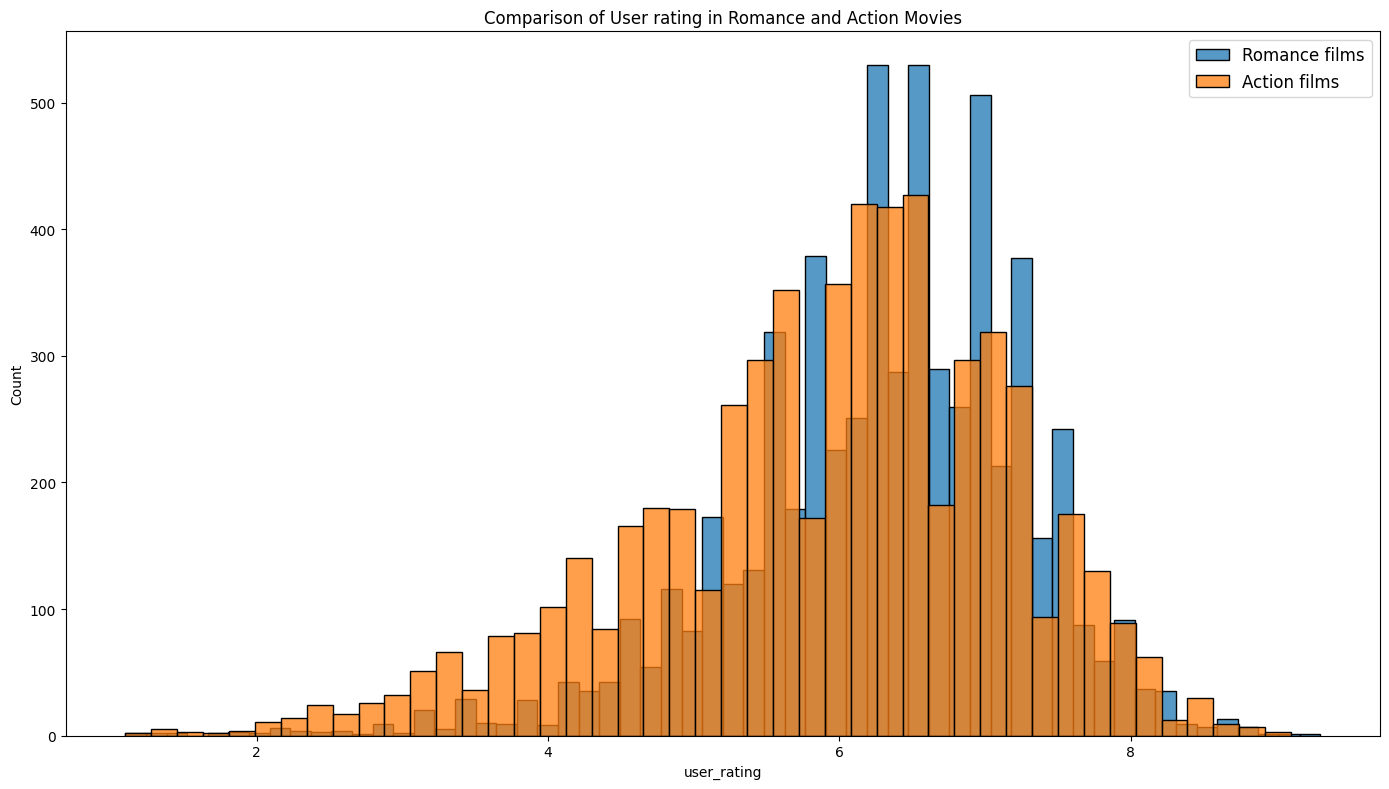

In [22]:
pyplot.title("Comparison of User rating in Romance and Action Movies")
sns.histplot(romance_films["user_rating"], kde=False, label= "Romance films")
sns.histplot(action_films["user_rating"], kde=False, label = "Action films")
pyplot.legend(prop={'size': 12})